# CS549 Final Project: Malicious URL Detection

**Group Members:**
- Nghi Tran
- Maksym Yelisyeyev
- Wasay Zaman


## Objectives

Our objective is to develop machine learning models to identify malicious URLs. Our project is separated into the following sections:
1. Data Preprocessing
2. Model Development:
  * Supervised Learning:
    * SVM
    * Logistic Regression
    * XGBoost
  * Hyperparameter Tuning
3. Model Evaluation
  * Performance Metrics
  * Comparative Analysis
4. Individual Contributions

# 1. Data Preprocessing
https://www.kaggle.com/datasets/siddharthkumar25/malicious-and-benign-urls

## Loading Data

In [1]:
# Inspecting a CSV file using pandas
import pandas as pd

urldata = pd.read_csv('../data/raw/urldata.csv')
urldata.head()

,Unnamed: 0,url,label,result
0,0,https://www.google.com,benign,0
1,1,https://www.youtube.com,benign,0
2,2,https://www.facebook.com,benign,0
3,3,https://www.baidu.com,benign,0
4,4,https://www.wikipedia.org,benign,0


In [2]:
# Removing the Unnamed column (run only once)
urldata = urldata.drop("Unnamed: 0", axis=1)
urldata.head()

,url,label,result
0,https://www.google.com,benign,0
1,https://www.youtube.com,benign,0
2,https://www.facebook.com,benign,0
3,https://www.baidu.com,benign,0
4,https://www.wikipedia.org,benign,0


In [3]:
# Checking for missing values
urldata.isnull().sum()

url       0
label     0
result    0
dtype: int64

In [4]:
urldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450176 entries, 0 to 450175
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     450176 non-null  object
 1   label   450176 non-null  object
 2   result  450176 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 10.3+ MB


In [5]:
# Normalizing URLs before parsing
from urllib.parse import urlparse
def normalize_url(url):
    if not isinstance(url, str):
        return ''
    url = url.strip()
    url = url.replace("[.]", ".") # Replace obfuscated dots
    if not url.startswith(('http://', 'https://')): # Add scheme if missing
        url = 'http://' + url
    return url

# Data Preprocessing
#### 1. Lengths
- URL Length
- Hostname Length
- Path Length
- Fist Directory Length
- Top Level Domain Length
- Query Length

In [7]:
from urllib.parse import urlparse
from tld import get_tld

# URL Length
urldata["url_length"] = urldata["url"].apply(lambda x: len(str(x)))

# Hostname Length
def hostname_length(url):
    url = normalize_url(url)
    parsed = urlparse(url)
    return len(parsed.hostname or '')
urldata["hostname_length"] = urldata["url"].apply(hostname_length)

# Path Length
def path_length(url):
    url = normalize_url(url)
    parsed = urlparse(url)
    return len(parsed.path)
urldata["path_length"] = urldata["url"].apply(path_length)

# First Directory Length
def first_directory_length(url):
    url = normalize_url(url)
    path = urlparse(url).path
    first_directory = path.split('/')[1] if len(path.split('/')) > 1 else ''
    return len(first_directory)
urldata["first_directory_length"] = urldata["url"].apply(first_directory_length)

# Top Level Domain Length
def tld_length(url):
    url = normalize_url(url)
    try:
        tld = get_tld(url, fail_silently=True)
        return len(tld) if tld else 0
    except:
        return 0
urldata["tld_length"] = urldata["url"].apply(tld_length)

# Query Length
def query_length(url):
    url = normalize_url(url)
    parsed = urlparse(url)
    return len(parsed.query)
urldata["query_length"] = urldata["url"].apply(query_length)

urldata.head()

,url,label,result,url_length,hostname_length,path_length,first_directory_length,tld_length,query_length
0,https://www.google.com,benign,0,22,14,0,0,3,0
1,https://www.youtube.com,benign,0,23,15,0,0,3,0
2,https://www.facebook.com,benign,0,24,16,0,0,3,0
3,https://www.baidu.com,benign,0,21,13,0,0,3,0
4,https://www.wikipedia.org,benign,0,25,17,0,0,3,0


#### 2. Counts
- Special Characters
    - !@#$%^&*()-_=+[]{}|;:'\",.<>?/\\`~
- Count Of 'www'
- Count Of Digits
- Count Of Letters
- Count Of Number Of Directories
- Count Of Number Of Subdomains
- Count Of Tokens In URL

In [9]:
import tldextract

def special_char_count(url):
    url = str(url)
    special_chars = "!@#$%^&*()-_=+[]{}|;:'\",.<>?/\\`~"
    count = sum(1 for c in url if c in special_chars)
    return count
urldata["special_char_count"] = urldata["url"].apply(special_char_count)

urldata["count-www"] = urldata["url"].apply(lambda x: str(x).count('www'))

# Digit Count
def digit_count(url):
    url = str(url)
    digits = sum(c.isdigit() for c in url)
    return digits
urldata["digit_count"] = urldata["url"].apply(digit_count)

# Letter Count
def letter_count(url):
    url = str(url)
    letters = sum(c.isalpha() for c in url)
    return letters
urldata["letter_count"] = urldata["url"].apply(letter_count)

# Directory Count
def dir_count(url):
    url = normalize_url(url)
    dir = urlparse(url).path
    return dir.count('/')
urldata["dir_count"] = urldata["url"].apply(dir_count)

# Subdomain Count
def subdomain_count(url):
    url = normalize_url(url)
    hostname = urlparse(url).hostname or ''
    ext = tldextract.extract(hostname)
    if not ext.subdomain:
        return 0
    return len(ext.subdomain.split('.'))
urldata["subdomain_count"] = urldata["url"].apply(subdomain_count)

# Query Parameter Count
def query_param_count(url):
    url = normalize_url(url)
    parsed = urlparse(url)
    query = parsed.query
    if query:
        return query.count('&') + 1
    return 0
urldata["query_param_count"] = urldata["url"].apply(query_param_count)

urldata.head()

,url,label,result,url_length,hostname_length,path_length,first_directory_length,tld_length,query_length,special_char_count,count-www,digit_count,letter_count,dir_count,subdomain_count,query_param_count
0,https://www.google.com,benign,0,22,14,0,0,3,0,5,1,0,17,0,1,0
1,https://www.youtube.com,benign,0,23,15,0,0,3,0,5,1,0,18,0,1,0
2,https://www.facebook.com,benign,0,24,16,0,0,3,0,5,1,0,19,0,1,0
3,https://www.baidu.com,benign,0,21,13,0,0,3,0,5,1,0,16,0,1,0
4,https://www.wikipedia.org,benign,0,25,17,0,0,3,0,5,1,0,20,0,1,0


#### 3. Binary Features
- Has IP
- Uses HTTPS
- Has Suspicious Extension
- Uses Shortener

In [10]:
import re
import ipaddress

# Has IP Address
def has_ip_address(url):
    url = normalize_url(url)
    host = urlparse(url).hostname or ''
    try:
        ipaddress.ip_address(host)
        return 1
    except ValueError:
        return 0
urldata["has_ip_address"] = urldata["url"].apply(has_ip_address)

# Uses HTTPS
def uses_https(url):
    url = normalize_url(url)
    return 1 if urlparse(url).scheme == 'https' else 0
urldata["uses_https"] = urldata["url"].apply(uses_https)

# Has Suspicious Extension
def suspicious_extension(url):
    url = normalize_url(url)
    suspicious_exts = ['.exe', '.zip', '.rar', '.scr', '.pif', '.bat', '.cmd', '.js', '.vbs']
    path = urlparse(url).path.lower()
    for ext in suspicious_exts:
        if path.endswith(ext):
            return 1
    return 0
urldata["suspicious_extension"] = urldata["url"].apply(suspicious_extension)

# Uses Shortening
shortening_services = re.compile( 
    r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|ow\.ly|t\.co|tinyurl|is\.gd|cli\.gs|' 
    r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|' 
    r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|' 
    r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|lnkd\.in|' 
    r'db\.tt|qr\.ae|adf\.ly|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|ity\.im|' 
    r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|' 
    r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|' 
    r'tr\.im|link\.zip\.net' 
    , re.IGNORECASE               # added this flag becuase we're casting to lower case in uses_shortening
)

def uses_shortening(url): 
    url = normalize_url(url) 
    hostname = (urlparse(url).hostname or '').lower()
    return 1 if shortening_services.search(hostname) else 0
urldata["uses_shortening"] = urldata["url"].apply(uses_shortening)

urldata.head()

,url,label,result,url_length,hostname_length,path_length,first_directory_length,tld_length,query_length,special_char_count,count-www,digit_count,letter_count,dir_count,subdomain_count,query_param_count,has_ip_address,uses_https,suspicious_extension,uses_shortening
0,https://www.google.com,benign,0,22,14,0,0,3,0,5,1,0,17,0,1,0,0,1,0,0
1,https://www.youtube.com,benign,0,23,15,0,0,3,0,5,1,0,18,0,1,0,0,1,0,0
2,https://www.facebook.com,benign,0,24,16,0,0,3,0,5,1,0,19,0,1,0,0,1,0,0
3,https://www.baidu.com,benign,0,21,13,0,0,3,0,5,1,0,16,0,1,0,0,1,0,0
4,https://www.wikipedia.org,benign,0,25,17,0,0,3,0,5,1,0,20,0,1,0,0,1,0,0


#### 4. Entropy
- Shannon Entropy

In [11]:
# Shannon Entropy
import math
def shannon_entropy(url):
    url = str(url)
    if not url:
        return 0
    freq = {}
    for char in url:
        freq[char] = freq.get(char, 0) + 1
    entropy = 0.0
    length = len(url)
    for char, count in freq.items():
        p = count / length
        entropy -= p * math.log2(p)
    return entropy
urldata["shannon_entropy"] = urldata["url"].apply(shannon_entropy)

urldata.head()

,url,label,result,url_length,hostname_length,path_length,first_directory_length,tld_length,query_length,special_char_count,...,digit_count,letter_count,dir_count,subdomain_count,query_param_count,has_ip_address,uses_https,suspicious_extension,uses_shortening,shannon_entropy
0,https://www.google.com,benign,0,22,14,0,0,3,0,5,...,0,17,0,1,0,0,1,0,0,3.663533
1,https://www.youtube.com,benign,0,23,15,0,0,3,0,5,...,0,18,0,1,0,0,1,0,0,3.762267
2,https://www.facebook.com,benign,0,24,16,0,0,3,0,5,...,0,19,0,1,0,0,1,0,0,3.855389
3,https://www.baidu.com,benign,0,21,13,0,0,3,0,5,...,0,16,0,1,0,0,1,0,0,3.880180
4,https://www.wikipedia.org,benign,0,25,17,0,0,3,0,5,...,0,20,0,1,0,0,1,0,0,3.813661


#### 5. Ratios
- Digit Ratio
- Letter Ratio
- Special Character Ratio

In [16]:
# Digit Ratio
def digit_ratio(url):
    url = str(url)
    digits = sum(c.isdigit() for c in url)
    length = len(url)
    return digits / length if length > 0 else 0
urldata["digit_ratio"] = urldata["url"].apply(digit_ratio)

# Letter Ratio
def letter_ratio(url):
    url = str(url)
    letters = sum(c.isalpha() for c in url)
    length = len(url)
    return letters / length if length > 0 else 0
urldata["letter_ratio"] = urldata["url"].apply(letter_ratio)

# Special Character Ratio
def special_char_ratio(url):
    url = str(url)
    special_chars = "!@#$%^&*()-_=+[]{}|;:'\",.<>?/\\`~"
    special_count = sum(1 for c in url if c in special_chars)
    length = len(url)
    return special_count / length if length > 0 else 0
urldata["special_char_ratio"] = urldata["url"].apply(special_char_ratio)

# Uppercase features
urldata["uppercase_count"] = urldata["url"].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
urldata["uppercase_ratio"] = urldata["uppercase_count"] / urldata["url_length"].replace(0, 1)


# Protocol features
urldata["has_protocol"] = urldata["url"].apply(
    lambda x: 1 if str(x).startswith(('http://', 'https://', 'ftp://')) else 0
)
urldata["is_bare_domain"] = urldata["url"].apply(
    lambda x: 1 if not str(x).startswith(('http://', 'https://')) and str(x).count('/') == 0 else 0
)


urldata.head().T

,0,1,2,3,4
url,https://www.google.com,https://www.youtube.com,https://www.facebook.com,https://www.baidu.com,https://www.wikipedia.org
label,benign,benign,benign,benign,benign
result,0,0,0,0,0
url_length,22,23,24,21,25
hostname_length,14,15,16,13,17
path_length,0,0,0,0,0
first_directory_length,0,0,0,0,0
tld_length,3,3,3,3,3
query_length,0,0,0,0,0
special_char_count,5,5,5,5,5


### Handling Missing Values
* Removing rows with missing values
* Imputation methods: filling the blanks with estimated values. This could be the mean, median, mode, the nearest data from the same columns,
* Interpolation methods: estimate missing values based on the values of surrounding data points


In [17]:
print("Missing values per column:")
feature_cols = [col for col in urldata.columns if col not in ['url', 'type', 'tld']]
missing = urldata[feature_cols].isnull().sum()
print(missing[missing > 0])

if urldata[feature_cols].isnull().sum().sum() == 0:
    print("\nNo missing values found in features!")
else:
    print(f"\nTotal missing values: {urldata[feature_cols].isnull().sum().sum()}")

Missing values per column:
Series([], dtype: int64)

No missing values found in features!


In [23]:
# Check if same URL has multiple different labels
duplicate_urls = urldata[urldata['url'].duplicated(keep=False)]

if len(duplicate_urls) > 0:
    # Group by URL and check if they have different types
    url_type_check = duplicate_urls.groupby('url')['type'].nunique()

    # URLs with multiple different labels
    conflicting_urls = url_type_check[url_type_check > 1]

    print(f"Total duplicate URL entries: {len(duplicate_urls)}")
    print(f"URLs with conflicting labels: {len(conflicting_urls)}")

    if len(conflicting_urls) > 0:
        for url in conflicting_urls[:3]:  # Show first 3
            labels = urldata[urldata['url'] == url]['label'].unique()
            print(f"     - {url[:50]}... : {labels}")
        if len(conflicting_urls) > 3:
            print(f"     ... and {len(conflicting_urls) - 3} more")
            
        # Remove conflicting URLs
        rows_before = len(urldata)
        urldata = urldata[~urldata['url'].isin(conflicting_urls)]
        print(f"   Removed {rows_before - len(urldata)} rows with conflicting labels")
    
    # Remove remaining duplicates (same URL, same label - safe to remove)
    duplicates_remaining = urldata['url'].duplicated().sum()
    if duplicates_remaining > 0:
        print(f"   Removing {duplicates_remaining} safe duplicates (same URL, same label)...")
        urldata = urldata.drop_duplicates(subset=['url'], keep='first')
    else:
        print("\nAll duplicate URLs have the same label - safe to remove duplicates")
else:
    print("No duplicate URLs found!")

No duplicate URLs found!


In [29]:
# URLs with conflicting labels
duplicate_urls = urldata[urldata['url'].duplicated(keep=False)]
url_type_check = duplicate_urls.groupby('url')['label'].nunique()
conflicting_urls = url_type_check[url_type_check > 1].index.tolist()

print(f"URLs with conflicting labels: {len(conflicting_urls)}")
print("These URLs will be REMOVED due to unreliable labeling:")
for url in conflicting_urls:
    labels = urldata[urldata['url'] == url]['type'].unique()
    print(f"  {url}: {labels}")

# Remove conflicting URLs: unreliable data
print(f"\nRemoving {len(urldata[urldata['url'].isin(conflicting_urls)])} rows with conflicting labels")
urldata_clean = urldata[~urldata['url'].isin(conflicting_urls)]

# Remove remaining duplicates: same URL, same label: reliable
print(f"Removing remaining duplicates (same URL, same label)")
urldata_clean = urldata_clean.drop_duplicates(subset=['url'], keep='first').reset_index(drop=True)

print(f"\nOriginal shape: {urldata.shape}")
print(f"After cleaning: {urldata_clean.shape}")
print(f"Total removed: {len(urldata) - len(urldata_clean)} rows")

urldata = urldata_clean

print("Final class distribution:")
print(urldata['label'].value_counts())

URLs with conflicting labels: 0
These URLs will be REMOVED due to unreliable labeling:

Removing 0 rows with conflicting labels
Removing remaining duplicates (same URL, same label)

Original shape: (450176, 28)
After cleaning: (450176, 28)
Total removed: 0 rows
Final class distribution:
label
benign       345738
malicious    104438
Name: count, dtype: int64


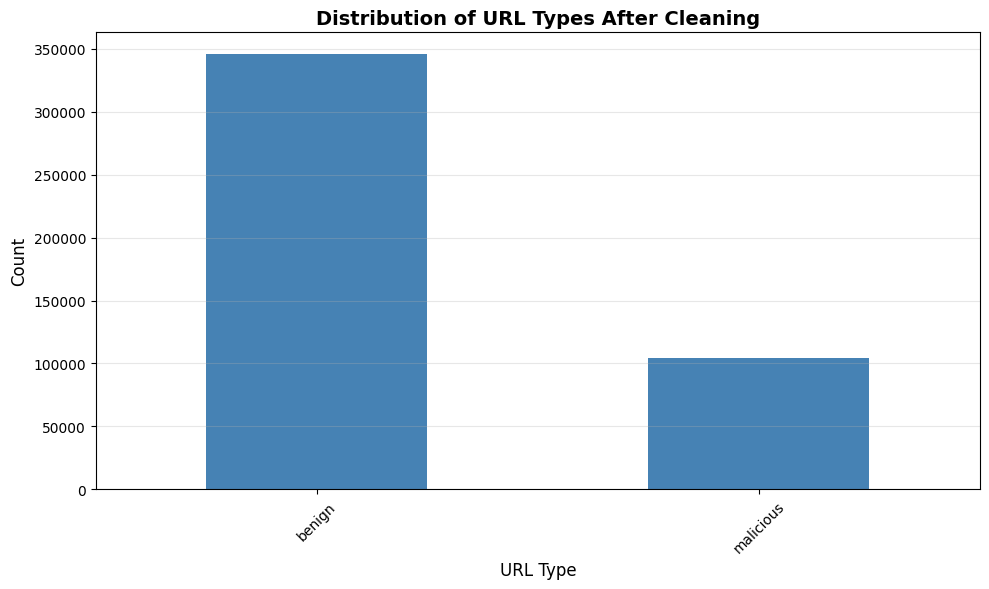

In [36]:
plt.figure(figsize=(10, 6))
urldata['label'].value_counts().plot(kind='bar', color='steelblue')
plt.title('Distribution of URL Types After Cleaning', fontsize=14, fontweight='bold')
plt.xlabel('URL Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Binary classification distribution:
is_malicious
0    345738
1    104438
Name: count, dtype: int64

Proportions:
is_malicious
0    0.768006
1    0.231994
Name: proportion, dtype: float64


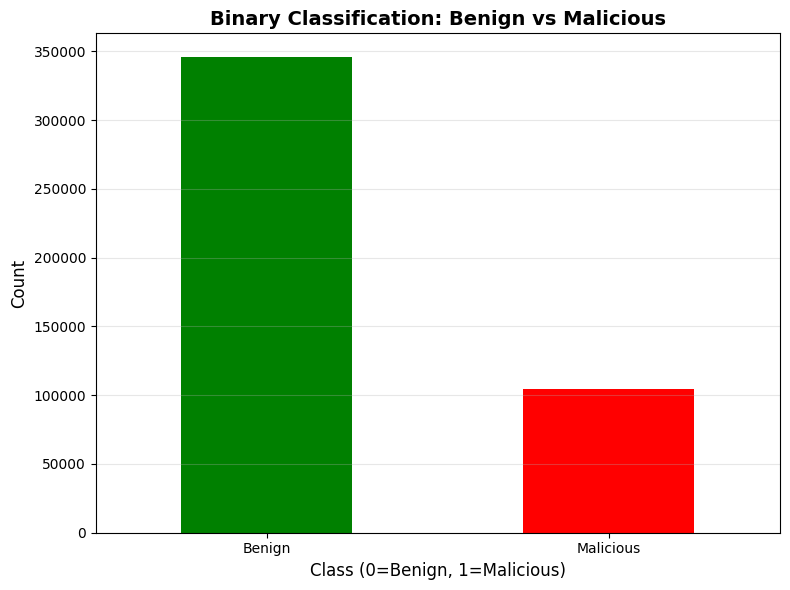

In [33]:
from matplotlib import pyplot as plt


urldata['is_malicious'] = (urldata['label'] != 'benign').astype(int)

print("\nBinary classification distribution:")
print(urldata['is_malicious'].value_counts())
print("\nProportions:")
print(urldata['is_malicious'].value_counts(normalize=True))

# Visualize binary distribution
plt.figure(figsize=(8, 6))
urldata['is_malicious'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Binary Classification: Benign vs Malicious', fontsize=14, fontweight='bold')
plt.xlabel('Class (0=Benign, 1=Malicious)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Benign', 'Malicious'], rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Splittting and Scaling

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Splitting the dataset into training and testing sets
X = urldata.drop(columns=["url", "label", "result"]) # Features
y = urldata["label"]

print(X.columns)

# Split is 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit scaler on training data
scaler = StandardScaler()
scaler.fit(X_train)

# Creating 0/1 labels for all models
y_train = (y_train == "malicious").astype(int)
y_test = (y_test == "malicious").astype(int)

# Transform both training and testing data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

Index(['url_length', 'hostname_length', 'path_length',
       'first_directory_length', 'tld_length', 'query_length',
       'special_char_count', 'count-www', 'digit_count', 'letter_count',
       'dir_count', 'subdomain_count', 'query_param_count', 'has_ip_address',
       'uses_https', 'suspicious_extension', 'uses_shortening',
       'shannon_entropy', 'digit_ratio', 'letter_ratio', 'special_char_ratio',
       'uppercase_count', 'uppercase_ratio', 'has_protocol', 'is_bare_domain',
       'is_malicious'],
      dtype='object')


# Evaluation

In [51]:
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    print(f"\n{'=' * 70}")
    print(f"{model_name}")
    print(f"{'=' * 70}")

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\nPerformance Metrics:")
    print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"  Recall:    {recall:.4f} ({recall*100:.2f}%)")
    print(f"  F1-Score:  {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix:")
    print(f"                     Predicted")
    print(f"                Benign    Malicious")
    print(f"Actual Benign     {cm[0][0]:7,}   {cm[0][1]:7,}")
    print(f"       Malicious  {cm[1][0]:7,}   {cm[1][1]:7,}")

    # ROC-AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    print(f"\nROC-AUC Score: {roc_auc:.4f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'fpr': fpr,
        'tpr': tpr
    }

# SVM

In [52]:
from sklearn.svm import LinearSVC
import time

start_time = time.time()
svm_model = LinearSVC(C=1.0, max_iter=5000)
svm_model.fit(X_train_scaled, y_train)
svm_train_time = time.time() - start_time
y_pred_svm = svm_model.predict(X_test_scaled)
y_pred_proba_svm = svm_model.decision_function(X_test_scaled)


svm_results = evaluate_model(y_test, y_pred_svm, y_pred_proba_svm, "Support Vector Machine (SVM) Model")


Support Vector Machine (SVM) Model

Performance Metrics:
  Accuracy:  1.0000 (100.00%)
  Precision: 1.0000 (100.00%)
  Recall:    1.0000 (100.00%)
  F1-Score:  1.0000

Confusion Matrix:
                     Predicted
                Benign    Malicious
Actual Benign      69,148         0
       Malicious        0    20,888

ROC-AUC Score: 1.0000


# Logistic Regression

In [53]:
from sklearn.linear_model import LogisticRegression

start_time = time.time()
lr_model = LogisticRegression(max_iter=5000)
lr_model.fit(X_train_scaled, y_train)
lr_train_time = time.time() - start_time
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

lr_results = evaluate_model(y_test, y_pred_lr, y_pred_proba_lr, "Logistic Regression")


Logistic Regression

Performance Metrics:
  Accuracy:  1.0000 (100.00%)
  Precision: 1.0000 (100.00%)
  Recall:    1.0000 (100.00%)
  F1-Score:  1.0000

Confusion Matrix:
                     Predicted
                Benign    Malicious
Actual Benign      69,148         0
       Malicious        0    20,888

ROC-AUC Score: 1.0000


# XGBoost

In [54]:
from xgboost import XGBClassifier

start_time = time.time()
xgb_model = XGBClassifier(random_state = 42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_train_time = time.time() - start_time
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

xgb_results = evaluate_model(y_test, y_pred_xgb, y_pred_proba_xgb, "XGBoost Classifier")


XGBoost Classifier

Performance Metrics:
  Accuracy:  1.0000 (100.00%)
  Precision: 1.0000 (100.00%)
  Recall:    1.0000 (100.00%)
  F1-Score:  1.0000

Confusion Matrix:
                     Predicted
                Benign    Malicious
Actual Benign      69,148         0
       Malicious        0    20,888

ROC-AUC Score: 1.0000




Comparative Model Evaluation Results



,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Training Time (s)
Model,,,,,,
Logistic Regression,1.0,1.0,1.0,1.0,1.0,0.46
SVM,1.0,1.0,1.0,1.0,1.0,1.79
XGBoost,1.0,1.0,1.0,1.0,1.0,2.21


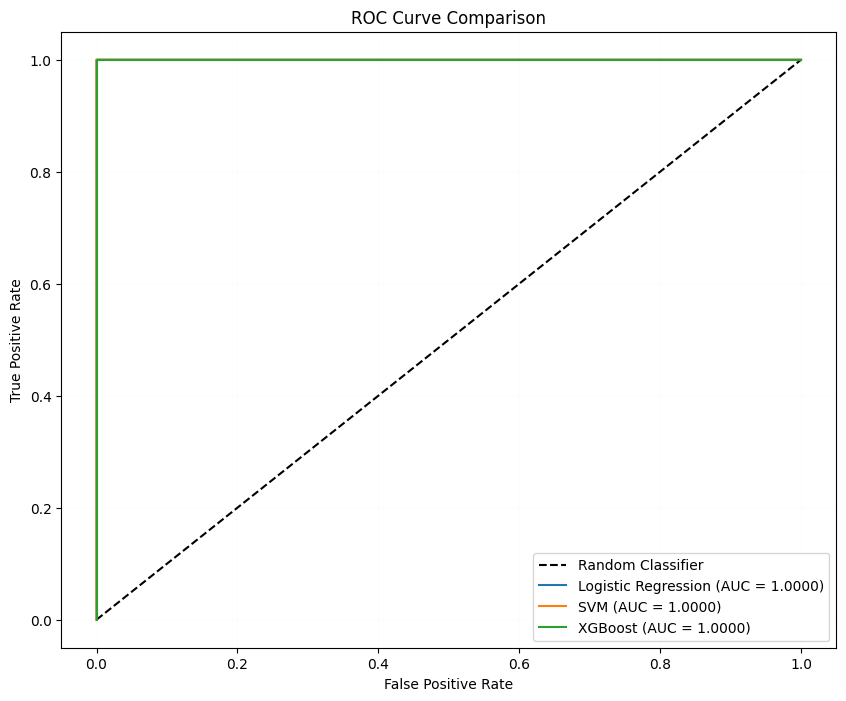

In [55]:
import matplotlib.pyplot as plt

print("\n" + "=" * 70)
print("\nComparative Model Evaluation Results")
print("\n" + "=" * 70)

# Collect results in a dictionary for easy DataFrame creation
all_results = {
    "Logistic Regression": lr_results,
    "SVM": svm_results,
    "XGBoost": xgb_results
}

metrics_df = pd.DataFrame({
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "ROC-AUC": [],
    "Training Time (s)": []
})

for model_name, results in all_results.items():
    # Add training time from respective variables
    if model_name == "Logistic Regression":
        train_time = lr_train_time
    elif model_name == "SVM":
        train_time = svm_train_time
    elif model_name == "XGBoost":
        train_time = xgb_train_time
    else:
        train_time = None

    metrics_df.loc[len(metrics_df)] = [
        model_name,
        results['accuracy'],
        results['precision'],
        results['recall'],
        results['f1'],
        results['roc_auc'],
        f"{train_time:.2f}" if train_time is not None else "N/A"
    ]

metrics_df.set_index('Model', inplace=True)

display(metrics_df.round(4))

# Optional: Plot ROC curves for comparison
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

for model_name, results in all_results.items():
    plt.plot(results['fpr'], results['tpr'], label=f'{model_name} (AUC = {results["roc_auc"]:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.03)
plt.show()